# Visualizing COVID19 outbreak in India
Visualizing COVID19 outbreak in India using GeoPandas and Bokeh
### [Run this notebook in Google Colab](https://colab.research.google.com/github/MoadComputer/covid19-visualization/blob/master/examples/COVID19_India.ipynb)

## Install dependencies

In [0]:
%%capture
! python3 -m pip install fiona geopandas visvalingamwyatt

## Import libraries

In [0]:
import os
import math
import json
import bokeh
import geopandas
import pandas as pd
import numpy as np

from bokeh.io.doc import curdoc
from bokeh.palettes import brewer
from bokeh.plotting import figure
from bokeh.plotting import show as plt_show
from bokeh.io import output_notebook, show, output_file
from bokeh.layouts import widgetbox, row, column, gridplot
from bokeh.tile_providers import Vendors, get_provider
from bokeh.models import Slider, HoverTool, Select, Div, Range1d, WMTSTileSource
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar, NumeralTickFormatter

## Load GeoJSON file of India

In [0]:
India_statewise = geopandas.read_file('https://github.com/MoadComputer/covid19-visualization/raw/master/data/GeoJSON_assets/India_statewise.geojson')

In [0]:
enable_minifiedGeoJSON=True

In [5]:
if not os.path.exists('./India_statewise.geojson') and enable_minifiedGeoJSON:
  ! wget https://github.com/MoadComputer/covid19-visualization/raw/master/data/GeoJSON_assets/India_statewise.geojson -O ./India_statewise.geojson

--2020-04-06 19:09:54--  https://github.com/MoadComputer/covid19-visualization/raw/master/data/GeoJSON_assets/India_statewise.geojson
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/MoadComputer/covid19-visualization/master/data/GeoJSON_assets/India_statewise.geojson [following]
--2020-04-06 19:09:54--  https://raw.githubusercontent.com/MoadComputer/covid19-visualization/master/data/GeoJSON_assets/India_statewise.geojson
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15744209 (15M) [text/plain]
Saving to: ‘./India_statewise.geojson’

./India_statewise.g 100%[===================>]  15.01M  25.6MB/s  

## Simplify GeoJSON geometry
GeoJSON geometry simplication is performed using Visvalingam-Whyatt polyline simplification algorithm. The motivation for simplifying GeoJSON geometry is to improve the map rendering times to a reasonable degree. The compromise here is in the level of geometrical details. If rendering times are not important (offline applications), use the original GeoJSON file without these simplification steps.

In [0]:
%%capture
if enable_minifiedGeoJSON:
  # Simplify using ratio of points
  ! vwsimplify --ratio 0.61803551 ./India_statewise.geojson -o ./India_statewise_simplified.geojson

  # Further simplify (minify) using the number of points to keep
  ! vwsimplify --number 21 /content/India_statewise_simplified.geojson -o ./India_statewise_minified.geojson

  # Simplify using ratio of points
  ! vwsimplify --ratio 0.5 ./India_statewise_minified.geojson -o ./India_statewise_atomified.geojson

  if os.path.exists('./India_statewise_atomified.geojson'):
    # Use atomified GeoJSON to generate the interactive map
    India_statewise = geopandas.read_file('./India_statewise_atomified.geojson')

In [7]:
India_statewise.crs = {'init': 'epsg:4326'}
India_statewise.head()

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


,state,geometry
0,Andaman and Nicobar Islands,"MULTIPOLYGON (((93.71976 7.20707, 93.71347 7.2..."
1,Andhra Pradesh,"MULTIPOLYGON (((81.39375 16.33380, 81.32692 16..."
2,Arunachal Pradesh,"POLYGON ((96.16261 29.38078, 96.27668 28.41882..."
3,Assam,"MULTIPOLYGON (((89.74323 26.30362, 89.73397 26..."
4,Bihar,"MULTIPOLYGON (((84.50720 24.26323, 84.49891 24..."


## Load COVID19 India data
The COVID19 data is aggregated from the [Ministry of Health and Family Welfare, Government of India](https://www.mohfw.gov.in/#state-data) website.

In [8]:
covid19_data = pd.read_csv('https://github.com/MoadComputer/covid19-visualization/raw/master/data/India_statewise/COVID19_India_statewise.csv')
covid19_data.head()

,ID,state,total_cases,discharged,deaths
0,1,Andhra Pradesh,226,1,3
1,2,Andaman and Nicobar Islands,10,0,0
2,3,Arunachal Pradesh,1,0,0
3,4,Assam,26,0,0
4,5,Bihar,30,0,1


## Display the list of states with no COVID19 reports

In [9]:
noCOVID19_list = list(set(list(India_statewise.state.values)) -set(list(covid19_data.state)))
print('A total of: {} states with no reports of COVID19 ...'.format(len(noCOVID19_list)))
print('\nStates in India with no COVID19 reports:')
for noCOVID19_state in noCOVID19_list:
  print('\n{} ...'.format(noCOVID19_state))

A total of: 7 states with no reports of COVID19 ...

States in India with no COVID19 reports:

Meghalaya ...

Daman and Diu ...

Sikkim ...

Lakshadweep ...

Nagaland ...

Tripura ...

Dadara and Nagar Havelli ...


## Combining geographical and COVID19 data

In [0]:
def covid19_json(covid_df, geo_df):
  merged_df = pd.merge(geo_df, covid_df, on='state', how='left')
  merged_df = merged_df.fillna(0)
  merged_json = json.loads(merged_df.to_json())
  json_data = json.dumps(merged_json)
  return {'json_data': json_data, 'data_frame': merged_df}

In [0]:
merged_data = covid19_json(covid19_data, India_statewise)
merged_json = merged_data['json_data']

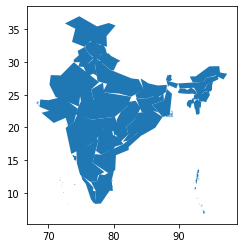

In [12]:
merged_data['data_frame'].plot()

In [0]:
def covid19_plot(covid19_geosource, 
                 input_df=None,
                 input_field=None,
                 plot_title=None):
  palette = brewer['Oranges'][8]
  palette = palette[::-1]
  hover = HoverTool(tooltips = [('State','@state'),
                                ('Total cases', '@total_cases'),
                                ('Total discharged/migrated', '@discharged'),
                                ('Total deaths', '@deaths')])
  color_mapper = LinearColorMapper(palette = palette, 
                                   low = 0, 
                                   high = int(10*(np.ceil(np.max(input_df[input_field].values)/10))))
  format_tick = NumeralTickFormatter(format=str(input_df[input_field].values))
  color_bar = ColorBar(color_mapper=color_mapper, 
                       label_standoff=10, 
                       formatter=format_tick,
                       border_line_color=None, 
                       location = (0, 0))
  plt = figure(title = plot_title,
               tools='save', 
               plot_height = 500, plot_width = 550,
               toolbar_location = 'left',
               #lod_factor=int(1e7),
               #lod_threshold=int(2),
               output_backend="webgl"
             )
  plt.xgrid.grid_line_color = None
  plt.ygrid.grid_line_color = None
  plt.axis.visible = False
  plt.patches('xs','ys', 
            source = covid19_geosource, 
            fill_color = {'field' : 'deaths', 
                          'transform' : color_mapper},
            line_color = 'red', 
            line_width = 1.25, 
            fill_alpha = 1)
  plt.add_layout(color_bar, 'right')
  plt.add_tools(hover)
  return plt

## Generate COVID19 plot

In [0]:
covid19_geosource=GeoJSONDataSource(geojson=merged_json)
plot_title='COVID-19 outbreak in India'
app_title='COVID19 India'

In [0]:
_covid19_plot = covid19_plot(covid19_geosource, 
                             input_df=covid19_data,
                             input_field='deaths',
                             plot_title=plot_title)

In [0]:
curdoc().title=app_title
covid19_layout = column(_covid19_plot)
curdoc().add_root(covid19_layout)

## Display the interactive COVID19 map for India
This generates an interactive COVID19 India outbreak map, within the notebook.
![Bokeh static output](https://github.com/MoadComputer/covid19-visualization/raw/master/examples/COVID19_India_Bokeh_output_20200406_131941.png)

In [0]:
output_notebook()
show(_covid19_plot)

## [Heroku hosted app](https://covid19india-visualization.herokuapp.com/COVID19_India)
The iframe displays a web version of this notebook, using Heroku.

In [0]:
import IPython
URL = 'https://covid19india-visualization.herokuapp.com/COVID19_India'
FRAME_WIDTH=600
FRAME_HEIGHT=550
iframe = '<iframe src={} width={} height={}></iframe>'.format(URL, 
                                                             FRAME_WIDTH, 
                                                             FRAME_HEIGHT)
IPython.display.HTML(iframe)